In [547]:
import json
import torch
import pandas as pd
import os
import random
import matplotlib.pyplot as plt
from PIL import Image

In [548]:
## collect fids where tags and captions do not have enough info

In [549]:
dataset = "GeoPlaces" ## "GeoImnet"

In [550]:
fid_to_embed = pd.read_csv("../hard_labels/{}_usa_asia_embedMatchPL.txt".format(dataset.lower()), header=None, sep=" ", names=["fid","label_embed"])

fid_to_tags = pd.read_csv("../hard_labels/{}_usa_asia_tagMatchPL.txt".format(dataset.lower()), header=None, sep=" ", names=["fid","label_tag"])

fid_to_class = pd.read_csv("../hard_labels/{}_usa_asia_combinedPL.txt".format(dataset.lower()), header=None, sep=" ", names=["fid","label_class"])

merged = pd.merge(fid_to_tags, fid_to_embed, on="fid").merge(fid_to_class, on="fid")

fid_to_gt = pd.read_csv("/home/tarun/GeoDA_Project/geoData/places205/asia_train.txt", header=None, sep=" ", names=["filename","label_gt"])
# fid_to_gt = pd.read_csv("/home/tarun/GeoDA_Project/geoData/geoILSVRC/asia_train.txt", header=None, sep=" ", names=["filename","label_gt"])
fid_to_gt['fid'] = fid_to_gt.filename.map(lambda v:int(v.split("/")[-1].split(".")[0]))

merged = pd.merge(fid_to_tags, fid_to_embed, on="fid").merge(fid_to_class, on="fid").merge(fid_to_gt, on="fid")

filtered_merged = merged[(merged['label_class'] == merged['label_gt']) & (merged['label_embed'] != merged['label_gt']) & (merged['label_tag'] != merged['label_gt'])]

valid_fids = list(filtered_merged.fid.values)

In [551]:
fid_to_embed = pd.read_csv("../hard_labels/{}_asia_usa_embedMatchPL.txt".format(dataset.lower()), header=None, sep=" ", names=["fid","label_embed"])

fid_to_tags = pd.read_csv("../hard_labels/{}_asia_usa_tagMatchPL.txt".format(dataset.lower()), header=None, sep=" ", names=["fid","label_tag"])

fid_to_class = pd.read_csv("../hard_labels/{}_asia_usa_combinedPL.txt".format(dataset.lower()), header=None, sep=" ", names=["fid","label_class"])

merged = pd.merge(fid_to_tags, fid_to_embed, on="fid").merge(fid_to_class, on="fid")

fid_to_gt = pd.read_csv("/home/tarun/GeoDA_Project/geoData/places205/usa_train.txt", header=None, sep=" ", names=["filename","label_gt"])
# fid_to_gt = pd.read_csv("/home/tarun/GeoDA_Project/geoData/geoILSVRC/usa_train.txt", header=None, sep=" ", names=["filename","label_gt"])
fid_to_gt['fid'] = fid_to_gt.filename.map(lambda v:int(v.split("/")[-1].split(".")[0]))

merged = pd.merge(fid_to_tags, fid_to_embed, on="fid").merge(fid_to_class, on="fid").merge(fid_to_gt, on="fid")

filtered_merged = merged[(merged['label_class'] == merged['label_gt']) & (merged['label_embed'] != merged['label_gt']) & (merged['label_tag'] != merged['label_gt'])]

valid_fids += list(filtered_merged.fid.values)

In [105]:
geoplaces = torch.load("../saved_features_geoplaces.pth")
geoimnet = torch.load("../saved_features_geoimnet.pth")

In [106]:
text , images = geoimnet['text'], geoimnet['image']
usa_text, asia_text = text['usa'], text['asia']
usa_images, asia_images = images['usa'], images['asia']

In [107]:
similarity_matrix = torch.matmul(torch.from_numpy(usa_images['feature']), torch.from_numpy(asia_images['feature']).T)
knn_neighbors = similarity_matrix.topk(k=5,dim=-1).indices
usa_to_asia_image = {}
for sidx, fid in enumerate(usa_images['ids']):
    usa_to_asia_image[fid] = [asia_images['ids'][idx] for idx in knn_neighbors[sidx].cpu().numpy()]

In [108]:
similarity_matrix = torch.matmul(torch.from_numpy(usa_text['feature']), torch.from_numpy(asia_text['feature']).T)
knn_neighbors = similarity_matrix.topk(k=5,dim=-1).indices
usa_to_asia_text = {}
for sidx, fid in enumerate(usa_text['ids']):
    usa_to_asia_text[fid] = [asia_text['ids'][idx] for idx in knn_neighbors[sidx].cpu().numpy()]

In [22]:
# cherry pick examples
usa_id_to_label = {fid:int(label.item()) for label, fid in zip(usa_images["labels"], usa_images["ids"])}
asia_id_to_label = {fid:int(label.item()) for label, fid in zip(asia_images["labels"], asia_images["ids"])}

In [552]:
valid_fids_knn = []
for usa_fid, asia_fid in usa_to_asia_image.items():
    usa_label = usa_id_to_label[usa_fid]
    asia_label_image = [asia_id_to_label[a] for a in asia_fid]
    asia_label_text = [asia_id_to_label[a] for a in usa_to_asia_text[usa_fid]]
#     if (usa_label not in asia_label_image) and (len(set(asia_label_text))==1) and (usa_label == asia_label_text[0]):
    if (usa_label not in asia_label_image) and (usa_label not in asia_label_text):
        valid_fids_knn.append(usa_fid)

In [553]:
# intersection_fids = []
# for v in valid_fids_knn:
#     afids = usa_to_asia_text[v]
#     if v in valid_fids and all([a in valid_fids for a in afids]):
#         intersection_fids.append(v)
intersection_fids = valid_fids_knn

In [554]:
len(intersection_fids)

41500

In [29]:
geonet = json.load(open("../metadata/geoimnet.json"))
root = "/newdata/tarun/datasets/GeoNet/metadata/GeoImnet/"
usa_id_to_path = {f["id"]:f["filename"] for f in geonet["usa_train"]["images"]}
asia_id_to_path = {f["id"]:f["filename"] for f in geonet["asia_train"]["images"]}

usa_id_to_path = {f:os.path.join(root,p) for f,p in usa_id_to_path.items()}
asia_id_to_path = {f:os.path.join(root,p) for f,p in asia_id_to_path.items()}

usa_id_to_meta = {m["image_id"]:m["caption"] for m in geonet["usa_train"]["metadata"]}
asia_id_to_meta = {m["image_id"]:m["caption"] for m in geonet["asia_train"]["metadata"]}

In [601]:
usa_fid = random.choice(intersection_fids)

usa_image = usa_id_to_path[usa_fid]
usa_meta = usa_id_to_meta[usa_fid]

label_name = usa_image.split("/")[-2]
print(usa_meta +"+" + label_name)

Creepin'+racing_boat


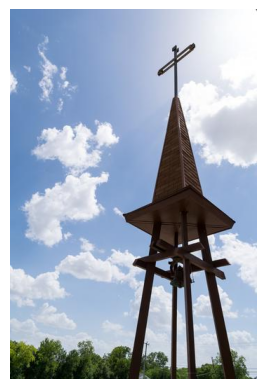

In [581]:
plt.imshow(Image.open(usa_image))
plt.axis('off');

In [589]:
asia_images = [asia_id_to_path[af] for af in usa_to_asia_image[usa_fid]]
asia_labels = list(map(lambda v:v.split("/")[-2], asia_images))

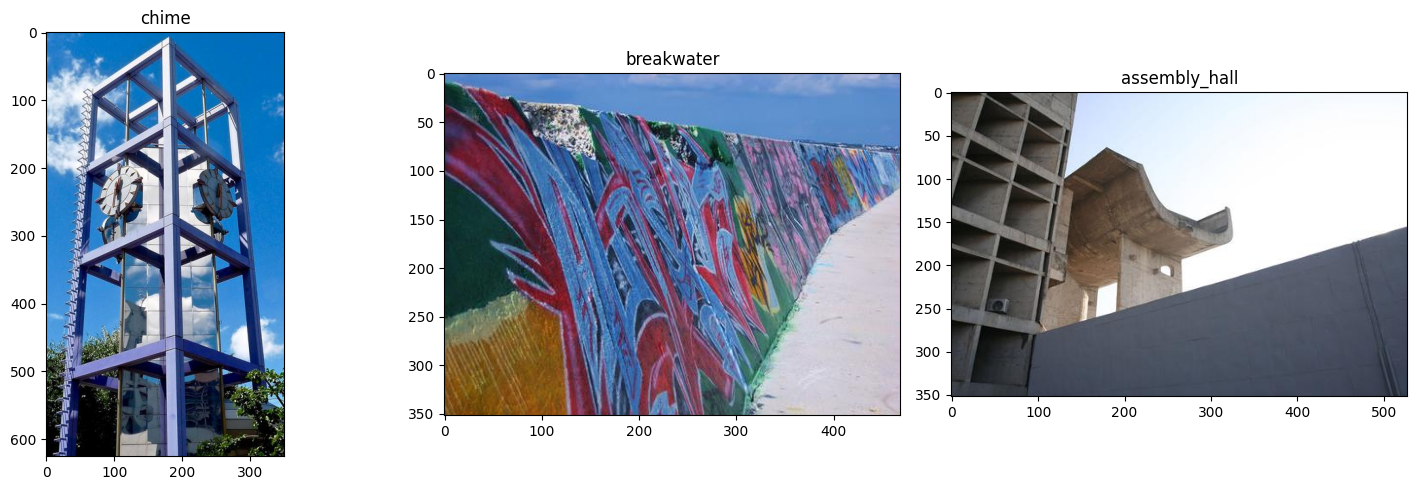

In [590]:
import matplotlib.pyplot as plt
import numpy as np

idx1, idx2, idx3 = 0,1,2

# Generate some example image data
image1 = Image.open(asia_images[idx1])
image2 = Image.open(asia_images[idx2])
image3 = Image.open(asia_images[idx3])

# Create subplots with 1 row and 3 columns
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Display the first image on the first subplot
axs[0].imshow(image1, cmap='viridis')
axs[0].set_title(asia_labels[idx1])

# Display the second image on the second subplot
axs[1].imshow(image2, cmap='plasma')
axs[1].set_title(asia_labels[idx2])

# Display the third image on the third subplot
axs[2].imshow(image3, cmap='inferno')
axs[2].set_title(asia_labels[idx3])

# Adjust layout for better spacing
plt.tight_layout()

# Show the plots
plt.show();

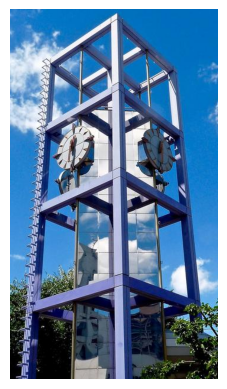

In [591]:
plt.imshow(Image.open(asia_images[idx1]))
plt.axis('off');

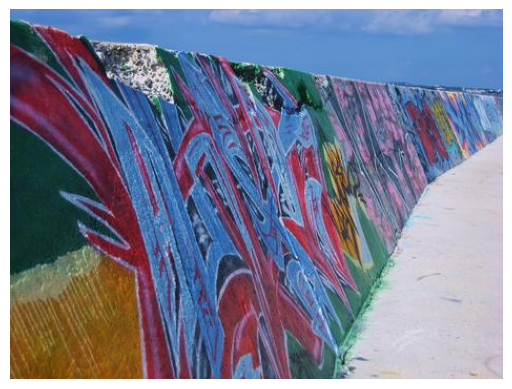

In [592]:
plt.imshow(Image.open(asia_images[idx2]))
plt.axis('off');

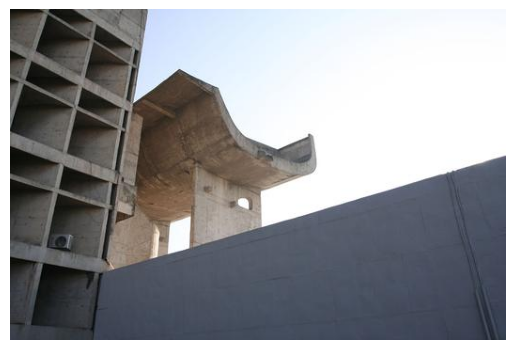

In [593]:
plt.imshow(Image.open(asia_images[idx3]))
plt.axis('off');

In [594]:
asia_images = [asia_id_to_path[af] for af in usa_to_asia_text[usa_fid]]
asia_meta = [asia_id_to_meta[af] for af in usa_to_asia_text[usa_fid]]
asia_labels = list(map(lambda v:v.split("/")[-2], asia_images))

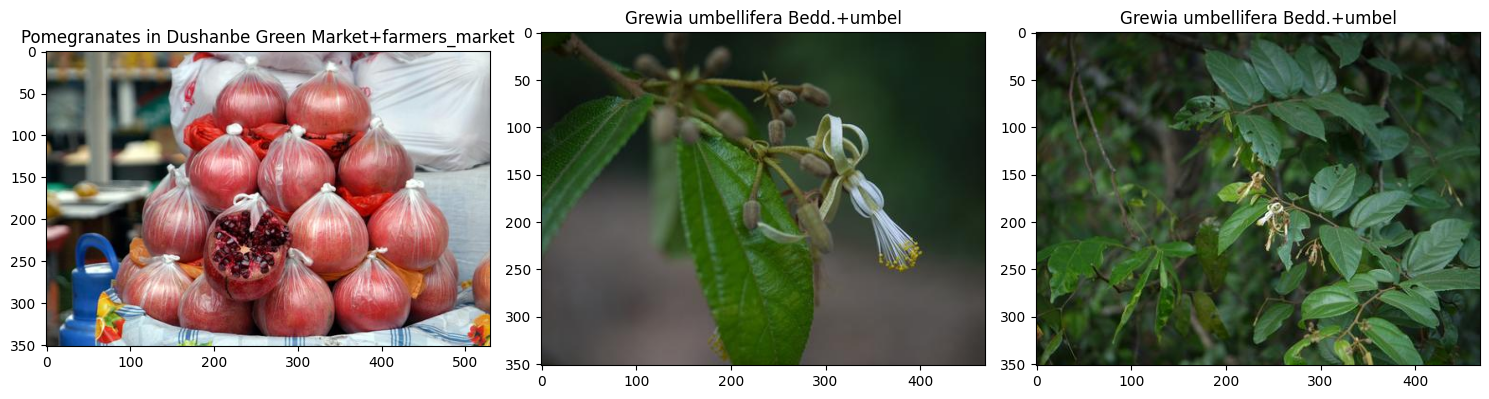

In [595]:
import matplotlib.pyplot as plt
import numpy as np

# Generate some example image data
image1 = Image.open(asia_images[0])
image2 = Image.open(asia_images[1])
image3 = Image.open(asia_images[2])

# Create subplots with 1 row and 3 columns
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Display the first image on the first subplot
axs[0].imshow(image1, cmap='viridis')
axs[0].set_title(asia_meta[0] + "+" + asia_labels[0])

# Display the second image on the second subplot
axs[1].imshow(image2, cmap='plasma')
axs[1].set_title(asia_meta[1] + "+" + asia_labels[1])

# Display the third image on the third subplot
axs[2].imshow(image3, cmap='inferno')
axs[2].set_title(asia_meta[2] + "+" + asia_labels[2])

# Adjust layout for better spacing
plt.tight_layout()

# Show the plots
plt.show();

In [596]:
asia_meta

['Pomegranates in Dushanbe Green Market',
 'Grewia umbellifera Bedd.',
 'Grewia umbellifera Bedd.',
 'Grewia umbellifera Bedd.',
 'Grewia umbellifera Bedd.']

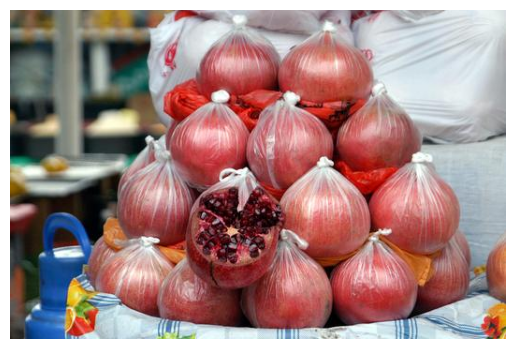

In [597]:
plt.imshow(Image.open(asia_images[0]))
plt.axis('off');

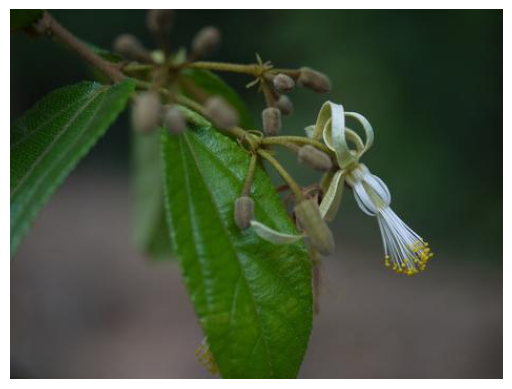

In [598]:
plt.imshow(Image.open(asia_images[1]))
plt.axis('off');

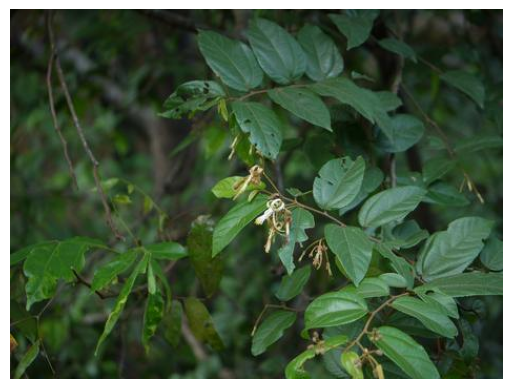

In [599]:
plt.imshow(Image.open(asia_images[2]))
plt.axis('off');

In [ ]:
[asia_id_to_meta[aid] for aid in usa_to_asia_text[usa_fid]]

In [36]:
usa_image, asia_images

('/newdata/tarun/datasets/GeoNet/metadata/GeoImnet/usa/train/sunglasses/5537285039.jpg',
 ['/newdata/tarun/datasets/GeoNet/metadata/GeoImnet/asia/train/sunglasses/2170959700.jpg',
  '/newdata/tarun/datasets/GeoNet/metadata/GeoImnet/asia/train/sunglasses/1569559528.jpg',
  '/newdata/tarun/datasets/GeoNet/metadata/GeoImnet/asia/train/sunglasses/1500608485.jpg'])